In [1]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.1.0


In [3]:
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils.gcs_dataset_info_files = lambda *args, **kwargs: None
gcs_utils.is_dataset_on_gcs = lambda *args, **kwargs: False

(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to C:\Users\jarvi\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteL4PA85\imdb_reviews-train.tfrecord
Shuffling and writing examples to C:\Users\jarvi\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteL4PA85\imdb_reviews-test.tfrecord
Shuffling and writing examples to C:\Users\jarvi\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteL4PA85\imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to C:\Users\jarvi\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [7]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [8]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [14]:
BUFFER_SIZE = 1000
padded_shapes = ([None],())

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32,padded_shapes=padded_shapes))

test_batches = (
    test_data
    .padded_batch(32,padded_shapes=padded_shapes))

In [15]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (32, 1179)
label shape: (32,)
Batch shape: (32, 1082)
label shape: (32,)


In [16]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6825 - accuracy: 0.5005 - val_loss: 0.6649 - val_accuracy: 0.5052
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.6208 - accuracy: 0.5534 - val_loss: 0.5948 - val_accuracy: 0.6167
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.5401 - accuracy: 0.6673 - val_loss: 0.5315 - val_accuracy: 0.6646
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4735 - accuracy: 0.7501 - val_loss: 0.4840 - val_accuracy: 0.8000
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4200 - accuracy: 0.8038 - val_loss: 0.4440 - val_accuracy: 0.8125
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3804 - accuracy: 0.8338 - val_loss: 0.4166 - val_accuracy: 0.8010
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3485 - accuracy: 0.8518 - val_loss: 0.3972 - val_accuracy: 0.8292
Epoch 

In [19]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 3s 3ms/step - loss: 0.3343 - accuracy: 0.8714- 3s 3ms/step - loss: Loss:  0.33434788933228654
Accuracy:  0.8714


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

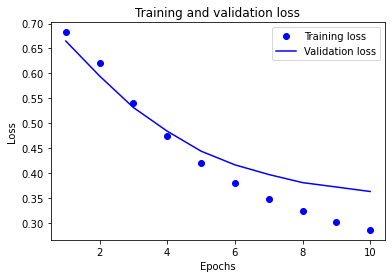

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

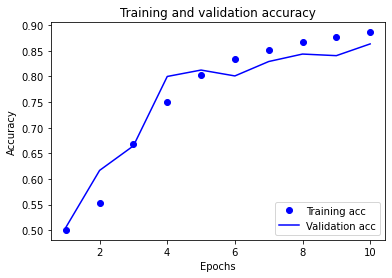

In [22]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()